# Methods

Starting a new notebook to address many of the thoughts in this comment: https://github.com/ocean-transport/argo-intern/issues/10#issuecomment-1574128413. 

This will likely include work to address:
- different ways to deal with boundaries when filtering
- a closer look into spice anomaly

In [1]:
import xarray as xr
import numpy as np
import gsw
import matplotlib.pyplot as plt
from importlib import reload
from cmocean import cm as cmo
import xrft

import filt_funcs as ff
import EV_funcs as ef
import plot_funcs as pf
import density_funcs as df
import funcs

In [2]:
reload(ff)
reload(ef)
reload(pf)
reload(df)
reload(funcs)

<module 'funcs' from '/home.ufs/amf2288/argo-intern/funcs.py'>

In [3]:
float_z = xr.open_dataset('202206_floats/float_ID:(1901700)_ds_z.nc')
float_r = xr.open_dataset('202206_floats/float_ID:(1901700)_ds_rho.nc')

## Boundaries

A few different approaches are possible here, a few of them are noted below:
- filter the whole profile
- filter the whole profile, then mask both boundaries (based on the filter scale)
- filter the whole profile, then mask the upper boundary (based on the mixed layer depth)
- select the profile below the mixed layer, then filter

First up, I'll need to get a handle on mixed layer datasets. Looking at the netcdf file with MLD for every argo profile here: http://mixedlayer.ucsd.edu/. It's a large file though (300+MB) so I have to figure out the best way to upload it here.

In [4]:
whole_prof = float_z.CT.isel(N_PROF=0)
part_prof  = whole_prof.where(float_z.PRES_INTERPOLATED>100).where(float_z.PRES_INTERPOLATED<1900)

CT_whole = ff.get_filt_prof(whole_prof, 100)
CT_part  = ff.get_filt_prof(part_prof , 100)

CT_filt = xr.Dataset(data_vars={'whole':(['PRES_INTERPOLATED'], CT_whole), 'part':(['PRES_INTERPOLATED'], CT_part)},
                     coords =  {'PRES_INTERPOLATED':float_z.PRES_INTERPOLATED})

CT_whole_mask = CT_filt.whole.where(float_z.PRES_INTERPOLATED>100).where(float_z.PRES_INTERPOLATED<1900)
CT_part_mask  = CT_filt.part .where(float_z.PRES_INTERPOLATED>200).where(float_z.PRES_INTERPOLATED<1800)

CT_filt['whole_mask'] = xr.DataArray(CT_whole_mask.values, dims=float_z.PRES_INTERPOLATED.dims)
CT_filt['part_mask']  = xr.DataArray(CT_part_mask.values,  dims=float_z.PRES_INTERPOLATED.dims)

Text(0.5, 1.0, 'Filtered CT Profiles')

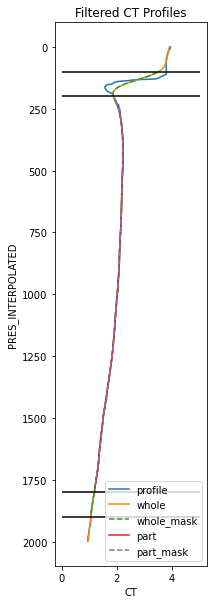

In [5]:
plt.figure(figsize=(6,10))
plt.subplot(122)
float_z.CT.isel(N_PROF=0).plot(y='PRES_INTERPOLATED',label='profile')

CT_filt.whole.plot(y='PRES_INTERPOLATED',label='whole')

CT_filt.whole_mask.plot(y='PRES_INTERPOLATED',label='whole_mask',linestyle='--')
CT_filt.part.plot(y='PRES_INTERPOLATED',label='part')
plt.hlines([100,1900],0,5,color='k')

CT_filt.part_mask.plot(y='PRES_INTERPOLATED',label='part_mask',linestyle='--')
plt.hlines([200,1800],0,5,color='k')

plt.gca().invert_yaxis()
plt.xlabel('CT')
plt.legend()
plt.title('Filtered CT Profiles')

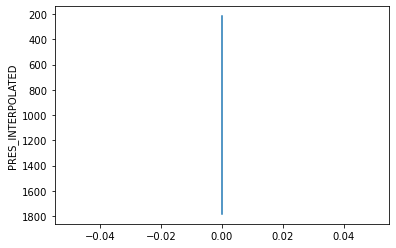

In [6]:
(CT_filt.whole - CT_filt.part).plot(y='PRES_INTERPOLATED')
plt.gca().invert_yaxis()

This is strange. Proving the filter with a different profile (or in this case a different section of the same profile) should return a different filtered signal, right? Also, CT_part should be from depth (100,900) but it looks like closer to (200,800). Additionally, part_mask should be from depth (200,800), but it's not exactly on those lines.

All told, there's a lot to look at here, and I feel like I'm getting no where. Time to move on and circle back with a fresh mind.

### Spice Anomaly

Want to compare Dhruv's method (computing spice based on glider reference temperature) to my method (using the defaults in gsw, then calculating the anomaly). Does removing the mean impact the other metrics we are looking at?

xrft.power_spectrum() doesn't work properly when NaNs or missing data is present, so it's really not going to work on the density grid. I think the best thing is to calculate spice and SPICE on the depth grid too? Or maybe make the comparison plot on the depth grid instead of density?

In [7]:
n=0
mean_prof_z  = float_z.SPICE.isel(PRES_INTERPOLATED=n).mean(skipna=True)
spice_prof_z = float_z.SPICE.isel(PRES_INTERPOLATED=n) - mean_prof_z

for n in range(1,len(float_z.PRES_INTERPOLATED)):
    mean_prof_z       = float_z.SPICE.isel(PRES_INTERPOLATED=n).mean(skipna=True)
    spice_prof_next_z = float_z.SPICE.isel(PRES_INTERPOLATED=n) - mean_prof_z

    spice_prof_z = xr.concat([spice_prof_z, spice_prof_next_z], dim='PRES_INTERPOLATED')

In [8]:
alpha_z = gsw.alpha(float_z.SA, float_z.CT, float_z.PRES_INTERPOLATED)

dCT_z = float_z.CT - float_z.CT.mean('N_PROF')
float_z['spice']= 2*1000*alpha_z*dCT_z

In [9]:
zdiff = float_z.spice - spice_prof_z

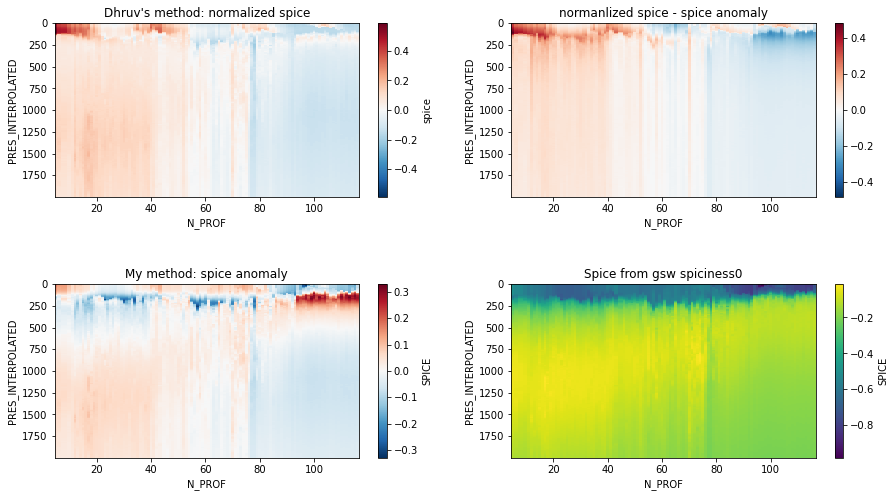

In [10]:
plt.figure(figsize=(15,8))

plt.subplot(2,2,1)
float_z.spice.plot(y='PRES_INTERPOLATED')
plt.gca().invert_yaxis()
plt.title("Dhruv's method: normalized spice")

plt.subplot(2,2,2)
zdiff.plot(y='PRES_INTERPOLATED')
plt.gca().invert_yaxis()
plt.title("normanlized spice - spice anomaly")

plt.subplot(2,2,3)
spice_prof_z.plot(y='PRES_INTERPOLATED')
plt.gca().invert_yaxis()
plt.title("My method: spice anomaly")

plt.subplot(2,2,4)
float_z.SPICE.plot(y='PRES_INTERPOLATED')
plt.gca().invert_yaxis()
plt.title("Spice from gsw spiciness0")

plt.subplots_adjust(hspace=0.5)

In [11]:
spice_spec_z = xrft.power_spectrum(float_z.spice,dim='PRES_INTERPOLATED', window=True)
SPICE_spec_z = xrft.power_spectrum(spice_prof_z ,dim='PRES_INTERPOLATED', window=True)

/home.ufs/amf2288/.conda/envs/argo/lib/python3.10/site-packages/xrft/xrft.py:49: FutureWarning: Please provide the name of window adhering to scipy.signal.windows. The boolean option will be deprecated in future releases.
  warnings.warn(
/home.ufs/amf2288/.conda/envs/argo/lib/python3.10/site-packages/xrft/xrft.py:49: FutureWarning: Please provide the name of window adhering to scipy.signal.windows. The boolean option will be deprecated in future releases.
  warnings.warn(


In [12]:
spice_spec_mean_z = xrft.power_spectrum(float_z.spice - float_z.spice.mean('N_PROF'),dim='PRES_INTERPOLATED', window=True)
SPICE_spec_mean_z = xrft.power_spectrum(spice_prof_z  - spice_prof_z .mean('N_PROF'),dim='PRES_INTERPOLATED', window=True)

/home.ufs/amf2288/.conda/envs/argo/lib/python3.10/site-packages/xrft/xrft.py:49: FutureWarning: Please provide the name of window adhering to scipy.signal.windows. The boolean option will be deprecated in future releases.
  warnings.warn(
/home.ufs/amf2288/.conda/envs/argo/lib/python3.10/site-packages/xrft/xrft.py:49: FutureWarning: Please provide the name of window adhering to scipy.signal.windows. The boolean option will be deprecated in future releases.
  warnings.warn(


Text(0.5, 1.0, 'plot 1 - plot 2')

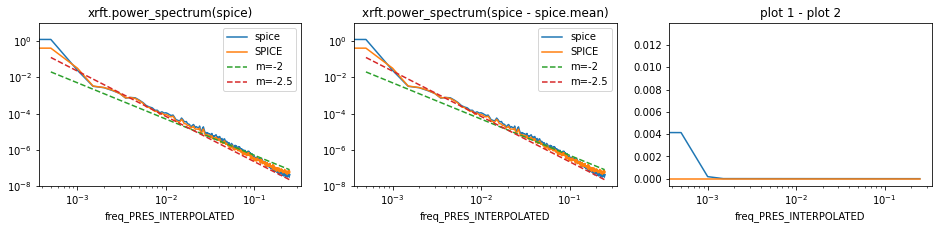

In [13]:
plt.figure(figsize=(16,3))

plt.subplot(1,3,1)
spice_spec_z.mean('N_PROF').plot(label='spice')
SPICE_spec_z.mean('N_PROF').plot(label='SPICE')

kz = spice_spec_z.freq_PRES_INTERPOLATED
plt.plot(kz, 5e-9*kz**(-2), '--', label='m=-2')
plt.plot(kz, 7e-10*kz**(-2.5), '--', label='m=-2.5')

plt.xscale('log')
plt.yscale('log')
plt.ylim(1e-8, 1e1)
plt.legend()
plt.title('xrft.power_spectrum(spice)')

plt.subplot(1,3,2)
spice_spec_mean_z.mean('N_PROF').plot(label='spice')
SPICE_spec_mean_z.mean('N_PROF').plot(label='SPICE')

kz = spice_spec_mean_z.freq_PRES_INTERPOLATED
plt.plot(kz, 5e-9*kz**(-2), '--', label='m=-2')
plt.plot(kz, 7e-10*kz**(-2.5), '--', label='m=-2.5')

plt.ylim(1e-8, 1e1)
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.title('xrft.power_spectrum(spice - spice.mean)')


plt.subplot(1,3,3)
(spice_spec_z - spice_spec_mean_z).mean('N_PROF').plot(label='spice')
(SPICE_spec_z - SPICE_spec_mean_z).mean('N_PROF').plot(label='SPICE')

plt.xscale('log')
plt.title('plot 1 - plot 2')

This compares the method of taking the power_spectrum of just spice to the mean spice subtracted from spice. It seems like the only effect this has is in the larger filter scale side of the spectrum and only for the method with a reference temperature gradient. This probably makes sense because in my method, the large scale signals have already been removed, so this has less of an effect. I think the next step is to see if (how?) this effects individual lines, not just the .mean('N_PROF') which is plotted here.

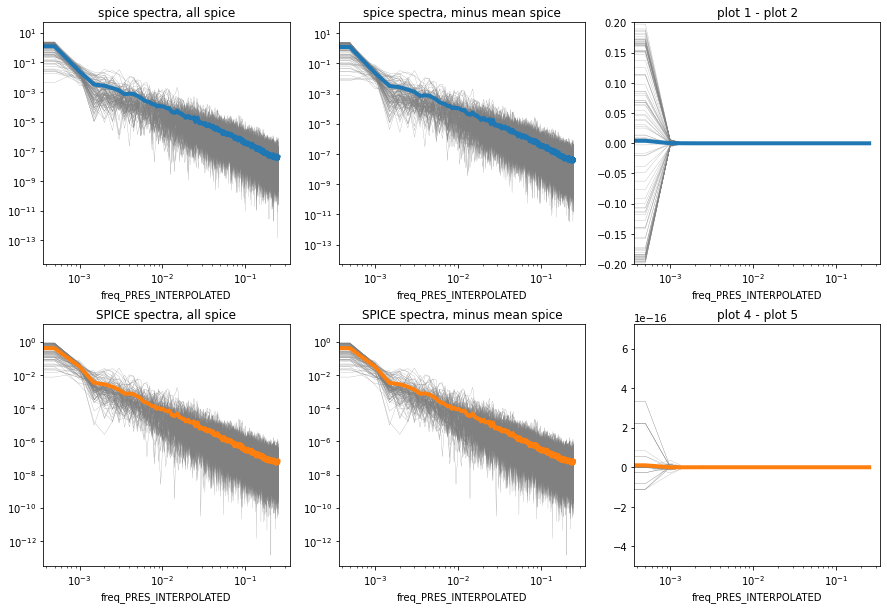

In [14]:
plt.figure(figsize=(15,10))

plt.subplot(2,3,1)
for n in range(0, len(spice_spec_z.N_PROF)):
    spice_spec_z.isel(N_PROF=n).plot(color='gray',linewidth=0.2)
spice_spec_z.mean('N_PROF').plot(color='tab:blue',linewidth=4)
plt.xscale('log')
plt.yscale('log')
plt.title('spice spectra, all spice')

plt.subplot(2,3,2)
for n in range(0, len(spice_spec_mean_z.N_PROF)):
    spice_spec_mean_z.isel(N_PROF=n).plot(color='gray',linewidth=0.2)
spice_spec_mean_z.mean('N_PROF').plot(color='tab:blue',linewidth=4)
plt.xscale('log')
plt.yscale('log')
plt.title('spice spectra, minus mean spice')

plt.subplot(2,3,3)
for n in range(0, len(spice_spec_z.N_PROF)):
    (spice_spec_z.isel(N_PROF=n) - spice_spec_mean_z.isel(N_PROF=n)).plot(color='gray',linewidth=0.2)
(spice_spec_z - spice_spec_mean_z).mean('N_PROF').plot(color='tab:blue',linewidth=4)
plt.xscale('log')
plt.ylim(-.2,.2)
plt.title('plot 1 - plot 2')

plt.subplot(2,3,4)
for i in range(0, len(SPICE_spec_z.N_PROF)):
    SPICE_spec_z.isel(N_PROF=i).plot(color='gray',linewidth=0.2)
SPICE_spec_z.mean('N_PROF').plot(color='tab:orange',linewidth=4)
plt.xscale('log')
plt.yscale('log')
plt.title('SPICE spectra, all spice')

plt.subplot(2,3,5)
for i in range(0, len(SPICE_spec_mean_z.N_PROF)):
    SPICE_spec_mean_z.isel(N_PROF=i).plot(color='gray',linewidth=0.2)
SPICE_spec_mean_z.mean('N_PROF').plot(color='tab:orange',linewidth=4)
plt.xscale('log')
plt.yscale('log')
plt.title('SPICE spectra, minus mean spice')

plt.subplot(2,3,6)
for n in range(0, len(spice_spec_z.N_PROF)):
    (SPICE_spec_z.isel(N_PROF=n) - SPICE_spec_mean_z.isel(N_PROF=n)).plot(color='gray',linewidth=0.2)
(SPICE_spec_z - SPICE_spec_mean_z).mean('N_PROF').plot(color='tab:orange',linewidth=4)
plt.xscale('log')

plt.title('plot 4 - plot 5')

plt.subplots_adjust(hspace=0.25)

---
---
___

In [15]:
n=0
mean_prof_r  = float_r.SPICE.isel(rho_grid=n).mean(skipna=True)
spice_prof_r = float_r.SPICE.isel(rho_grid=n) - mean_prof_r

for n in range(1,len(float_r.rho_grid)):
    mean_prof_r       = float_r.SPICE.isel(rho_grid=n).mean(skipna=True)
    spice_prof_next_r = float_r.SPICE.isel(rho_grid=n) - mean_prof_r

    spice_prof_r = xr.concat([spice_prof_r, spice_prof_next_r], dim='rho_grid')

In [16]:
alpha_r = gsw.alpha(float_r.SA, float_r.CT, float_r.PRES_INTERPOLATED)

dCT_r = float_r.CT - float_r.CT.mean('N_PROF_NEW')
float_r['spice']= 2*1000*alpha_r*dCT_r

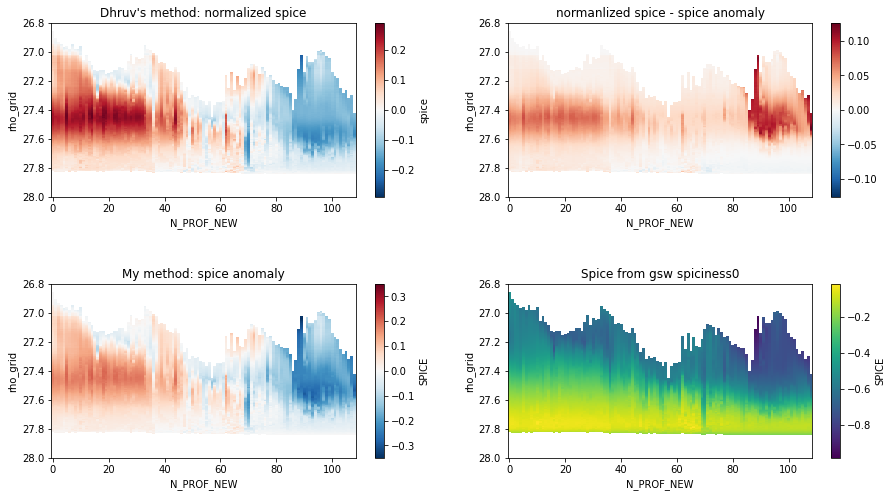

In [17]:
plt.figure(figsize=(15,8))

plt.subplot(2,2,1)
float_r.spice.plot()
plt.gca().invert_yaxis()
plt.title("Dhruv's method: normalized spice")

plt.subplot(2,2,2)
(float_r.spice - spice_prof_r).plot()
plt.gca().invert_yaxis()
plt.title("normanlized spice - spice anomaly")

plt.subplot(2,2,3)
spice_prof_r.plot()
plt.gca().invert_yaxis()
plt.title("My method: spice anomaly")

plt.subplot(2,2,4)
float_r.SPICE.plot()
plt.gca().invert_yaxis()
plt.title("Spice from gsw spiciness0")

plt.subplots_adjust(hspace=0.5)

In [18]:
spice_spec_r = xrft.power_spectrum(float_r.spice.dropna(dim='N_PROF_NEW') - float_r.spice.mean('N_PROF_NEW'),dim='rho_grid', window=True)
SPICE_spec_r = xrft.power_spectrum(spice_prof_r.dropna(dim='N_PROF_NEW')  - spice_prof_r .mean('N_PROF_NEW'),dim='rho_grid', window=True)

/home.ufs/amf2288/.conda/envs/argo/lib/python3.10/site-packages/xrft/xrft.py:49: FutureWarning: Please provide the name of window adhering to scipy.signal.windows. The boolean option will be deprecated in future releases.
  warnings.warn(
/home.ufs/amf2288/.conda/envs/argo/lib/python3.10/site-packages/xrft/xrft.py:49: FutureWarning: Please provide the name of window adhering to scipy.signal.windows. The boolean option will be deprecated in future releases.
  warnings.warn(


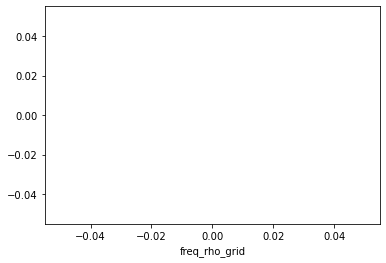

In [19]:
spice_spec_r.mean('N_PROF_NEW').plot()
SPICE_spec_r.mean('N_PROF_NEW').plot()

## Mixed Layer Depth

In [76]:
MLD = xr.open_dataset('Argo_mixedlayers_all_04142022.nc')

In [77]:
MLD

<xarray.Dataset>
Dimensions:        (iNPROF: 2480040)
Dimensions without coordinates: iNPROF
Data variables: (12/16)
    da_mld         (iNPROF) float64 ...
    da_mlpd        (iNPROF) float64 ...
    da_mls         (iNPROF) float64 ...
    da_mlt         (iNPROF) float64 ...
    dt_mld         (iNPROF) float64 ...
    dt_mlpd        (iNPROF) float64 ...
    ...             ...
    profilelat     (iNPROF) float64 ...
    profilelon     (iNPROF) float64 ...
    profilenumber  (iNPROF) float64 ...
    status         (iNPROF) float64 ...
    ta_mld         (iNPROF) float64 ...
    tt_mld         (iNPROF) float64 ...
Attributes:
    description:  This file was created using \n matlab R2019b with NETCDF Li...
    date:         17-Jun-2022

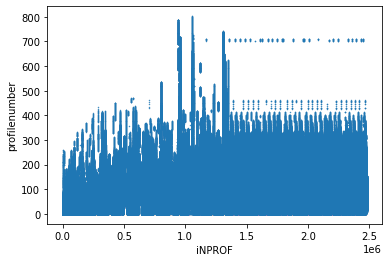

In [64]:
plt.scatter(MLD.iNPROF, MLD.profilenumber,s=0.2)
plt.xlabel('iNPROF')
plt.ylabel('profilenumber')

plt.savefig('')

Based on this, it seems like 'profilenumber' is a nonunique identifier, but I have no idea what it means then. Conversely, it seems like iNPROF could be a unique identifier (because there are way more values) but I don't know what it corresponds to in the datasets I've loaded. 
For float_z below:
- N_PROF (I think) is the profile order as loaded, without the profiles removed for not having a high enough sample frequency
- N_PROF_NEW is arbitrary because I've created it
- CYCLE_NUMBER honestly I have no idea what this means
- PLATFORM_NUMBER this is unique to each float, but obviously shared by every profile collected by the same float
- TIME seems like it would be a unique identifier, however it's not present in MLD

So before I can actually use MLD for anything, I have to figure out this profile identification issue.

In [78]:
float_z

<xarray.Dataset>
Dimensions:                (N_PROF: 109, PRES_INTERPOLATED: 1000)
Coordinates:
  * N_PROF                 (N_PROF) int64 5 6 8 10 11 12 ... 112 113 114 115 116
    TIME                   (N_PROF) datetime64[ns] 2014-02-18T15:27:22 ... 20...
    LATITUDE               (N_PROF) float64 -51.09 -51.21 ... -64.26 -63.67
    LONGITUDE              (N_PROF) float64 0.2698 0.2097 0.6125 ... 35.84 37.0
  * PRES_INTERPOLATED      (PRES_INTERPOLATED) int64 0 2 4 6 ... 1994 1996 1998
    N_PROF_NEW             (N_PROF) int64 0 1 2 3 4 5 ... 104 105 106 107 108
Data variables: (12/13)
    CONFIG_MISSION_NUMBER  (N_PROF) int32 4 4 4 4 4 4 4 4 4 ... 4 4 4 4 4 4 4 4
    CT                     (N_PROF, PRES_INTERPOLATED) float64 3.934 ... 0.1845
    CYCLE_NUMBER           (N_PROF) int32 5 6 8 10 11 12 ... 124 125 126 127 128
    DATA_MODE              (N_PROF) object 'D' 'D' 'D' 'D' ... 'D' 'D' 'R' 'D'
    DIRECTION              (N_PROF) object 'A' 'A' 'A' 'A' ... 'A' 'A' 'A' 'A'
    PLATFORM_NUMBER        (N_PROF) int32 1901700 1901700 ... 1901700 1901700
    ...                     ...
    PSAL                   (N_PROF, PRES_INTERPOLATED) float64 ...
    SA                     (N_PROF, PRES_INTERPOLATED) float64 ...
    SIG0                   (N_PROF, PRES_INTERPOLATED) float64 ...
    TEMP                   (N_PROF, PRES_INTERPOLATED) float64 ...
    SPICE                  (N_PROF, PRES_INTERPOLATED) float64 ...
    spice                  (N_PROF, PRES_INTERPOLATED) float64 0.5205 ... -0....
Attributes:
    DATA_ID:              ARGO
    DOI:                  http://doi.org/10.17882/42182
    Fetched_from:         /swot/SUM05/dbalwada/Argo_sync
    Fetched_by:           amf2288
    Fetched_date:         2023/06/01
    Fetched_constraints:  phy;WMO1901700
    Fetched_uri:          
    history:              Variables filtered according to DATA_MODE; Variable...